# Experimenting with CNNs 

This notebook has lots of experiments and random snippets of code as this is where we make a lot of efforts to innovate and play around.

In [24]:

import pandas as pd 
import torch 

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel

import dask.dataframe as dd 
import numpy as np
import torch.nn as nn
import importlib
import pickle
import utils
import data_processing_utils
import models

importlib.reload(utils)
from utils import *
importlib.reload(data_processing_utils)
from data_processing_utils import *
importlib.reload(models)
from models import *
from sys import getsizeof


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
grouped_df = pd.read_csv("./../data/haha-longer-mid.csv")
print(grouped_df)

         game_id                                              moves  \
0       00VRM44j  e2e4 g8f6 e4e5 f6g8 f1b5 f7f6 e5e6 c7c6 e6d7 c...   
1       0MG5pz3L  c2c4 g7g6 e2e4 f8g7 d2d3 d7d6 f1e2 g8f6 g1f3 e...   
2       0MV7dmua  e2e4 e7e5 f2f4 e5f4 g1f3 d7d5 e4d5 d8d5 b1c3 d...   
3       0UNsyqEb  d2d4 d7d5 c2c4 g8f6 b1c3 c8f5 c1g5 e7e6 e2e3 h...   
4       10mypbCS  d2d4 g7g6 c1h6 f8h6 g1f3 g8f6 e2e3 b8c6 f1b5 d...   
...          ...                                                ...   
466483  yT5CKw8c  g1f3 e7e6 b1c3 d7d5 d2d4 g8f6 c1g5 c7c5 e2e3 h...   
466484  yxAYsxBu  e2e4 e7e5 d2d4 e5d4 c2c3 d4c3 f1c4 c3b2 c1b2 f...   
466485  zLOF4boA  d2d4 c7c5 d4c5 b8c6 a2a3 g7g6 g1f3 f8g7 c2c3 e...   
466486  zimmRKoi  e2e4 e7e5 g1f3 d7d6 f1c4 c7c6 h2h3 d8e7 e1g1 c...   
466487  zzidHYZH  e2e4 e7e6 d2d4 d7d5 e4e5 c7c5 c2c3 d8b6 g1f3 b...   

        white_elo  black_elo  white_active  \
0            1523       1500          True   
1            1538       1580          True   
2        

In [3]:
with open('./../data/full_vocab_no_checkmate.pkl', 'rb') as inp:
    vocab = pickle.load(inp)

In [14]:
trainX, fens, trainY, vocab = df_to_data(grouped_df, vocab, board_only=True, sampling_rate=0.0875, with_checkmate=False)

In [11]:
len(vocab.id_to_move)

8212

Now that we've finished processing the data, let's now load in the data (assuming we're starting from fresh)

In [3]:
# Function to load a memmap file
def load_memmap(filename, dtype, shape):
    # Load the memmap file with read-only mode
    return np.memmap(filename, dtype=dtype, mode='r', shape=shape)

# Assuming you know the dtype and shape, for example:
# For trainX_sequences
dtype_trainX_sequences = np.int64  # or the correct dtype for your data
shape_trainX_sequences = (3038976, 16)  # replace with the correct shape
trainX_sequences = load_memmap('./../data/jan-march/trainX_sequences.memmap', dtype_trainX_sequences, shape_trainX_sequences)

# For trainX
dtype_trainX = np.int64  # or the correct dtype for your data
shape_trainX = (3038976, 12, 8, 8)  # replace with the correct shape
trainX = load_memmap('./../data/jan-march/trainX.memmap', dtype_trainX, shape_trainX)

# For trainY
dtype_trainY = np.int64  # or the correct dtype for your data
shape_trainY = (3038976,)  # replace with the correct shape
trainY = load_memmap('./../data/jan-march/trainY.memmap', dtype_trainY, shape_trainY)

# For trainX_seqlengths
dtype_trainX_seqlengths = np.int64  # or the correct dtype for your data
shape_trainX_seqlengths = (3038976,)  # replace with the correct shape
trainX_seqlengths = load_memmap('./../data/jan-march/trainX_seqlengths.memmap', dtype_trainX_seqlengths, shape_trainX_seqlengths)

Functions for training

In [5]:
def train_cnn(device, model, train_loader, val_loader, criterion, optimizer, num_epochs, learn_decay):
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    val_3_accuracy = []
    #swa_model = AveragedModel(model)
    #swa_start = 1
    for epoch in range(num_epochs):
        train_correct = 0
        train_total = 0
        training_loss = 0.0
        # Training
        model.train()
        count = 0
        for boards, fens, labels in train_loader:
            count += 1
            boards, labels = boards.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            # Forward Pass
            output = model(boards)
            loss = criterion(output, labels)
            # Backpropogate & Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # For logging purposes
            training_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            if count % 1000 == 0:
                print(f'Epoch {epoch+1}, Batch: {count}| Training Loss: {training_loss/count}')
        # if epoch >= swa_start:
        #     swa_model.update_parameters(model)
        # torch.optim.swa_utils.update_bn(train_loader, swa_model)
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        validation_loss = 0.0
        if val_loader is not None:
            with torch.no_grad():
                val_correct = 0
                val_total = 0
                val_top3_correct = 0
                validation_loss = 0

                for boards, fens, labels in val_loader:
                    boards, labels = boards.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                    outputs = model(boards)
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    val_top3_correct += top_3_accuracy(labels, outputs) * labels.size(0)
                    loss = criterion(outputs, labels)
                    validation_loss += loss.item()

                val_loss_values.append(validation_loss / len(val_loader))
                val_accuracy = 100 * val_correct / val_total
                val_top3_accuracy = 100 * val_top3_correct / val_total
                val_error.append(100 - val_accuracy)
                val_3_accuracy.append(val_top3_accuracy)

        # Log Model Performance  
        train_loss_values.append(training_loss)
        train_error.append(100-100*train_correct/train_total)
        print(f'Epoch {epoch+1}, Training Loss: {training_loss/len(train_loader)}, Validation Error: {val_error[-1]}, Validation Top-3 Accuracy: {val_3_accuracy[-1]}, Training Error: {train_error[-1]}')
        if epoch >0 and epoch%5 == 0:
            for op_params in optimizer.param_groups:
                op_params['lr'] = op_params['lr'] * learn_decay
    return train_error,train_loss_values, val_error, val_loss_values, None

Now let's train

In [18]:
dataset = CNNDataset(trainX, fens, trainY)
# Calculate split sizes
total_size = len(dataset)
print(total_size)
train_size = int(0.97 * total_size)
val_size = int(total_size * 0.02)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)

2145095
2080742


In [17]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Experiment 1 (Random CNN Architecture)
```
class ChessCNN(nn.Module):
    def __init__(self, d_out):
        super(ChessCNN, self).__init__()
        # Assuming each channel represents a different piece type (e.g., 12 channels for 6 types each for black and white)
        self.conv1 = nn.Conv2d(6, 12, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(12, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Assuming an 8x8 chess board
        self.fc2 = nn.Linear(128, d_out)

    def forward(self, x):
        # Apply convolutions
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
```

In [8]:
# We're scaling the model size so let's bring in more data as well
train_size = int(0.95 * total_size)
val_size = int(total_size * 0.04)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)

# Reload the data with particular batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
NUM_EPOCHS = 4
d_out = len(vocab.id_to_move.keys())
model = ChessCNN_no_pooling(d_out) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 2e-3
weight_decay=0
learn_decay = 0.5
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1801


/home/nathaniel/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


668207


Epoch 1, Training Loss: 6.236871045211266, Validation Error: 94.66666666666667, Validation Top-3 Accuracy: 9.333333373069763, Training Error: 97.83453636868407
Epoch 2, Training Loss: 5.539710554583319, Validation Error: 96.0, Validation Top-3 Accuracy: 13.333333373069763, Training Error: 95.61354802887286
Epoch 3, Training Loss: 5.401360265139876, Validation Error: 92.0, Validation Top-3 Accuracy: 16.00000003973643, Training Error: 95.00277623542476
Epoch 4, Training Loss: 5.339312701389708, Validation Error: 93.33333333333333, Validation Top-3 Accuracy: 16.00000003973643, Training Error: 94.50305385896723


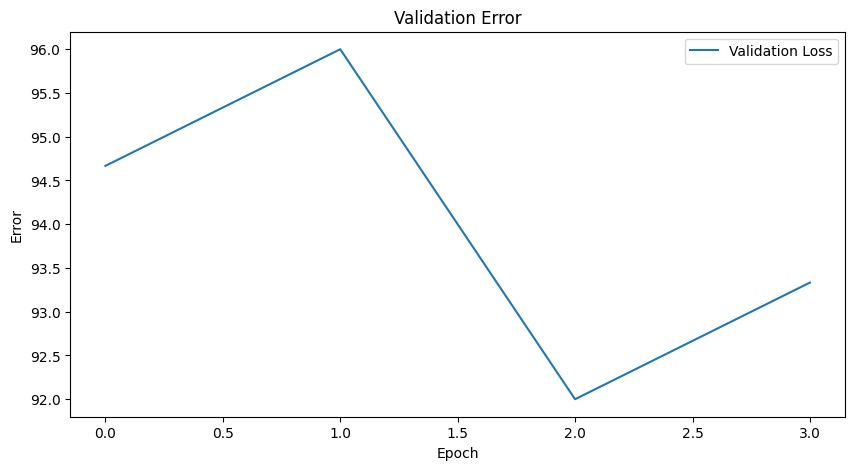

<Figure size 640x480 with 0 Axes>

In [9]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_cnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('validation_error_model_rnn.png')  # This will save the plot as an image

## Experiment 2 (Random CNN + Batch Norm)

In [ ]:
# We're scaling the model size so let's bring in more data as well
train_size = int(0.95 * total_size)
val_size = int(total_size * 0.04)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)

# Reload the data with particular batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
NUM_EPOCHS = 4
d_out = len(vocab.id_to_move.keys())
# We modified it to have batch norm
model = ChessCNN_no_pooling(d_out) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 2e-3
weight_decay=0
learn_decay = 0.5
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1634273
1266214


Epoch 1, Batch: 1000| Training Loss: 5.300418655395508
Epoch 1, Batch: 2000| Training Loss: 5.094209085345268
Epoch 1, Batch: 3000| Training Loss: 4.974344409783681
Epoch 1, Batch: 4000| Training Loss: 4.8837818021178245
Epoch 1, Batch: 5000| Training Loss: 4.809753782558441
Epoch 1, Batch: 6000| Training Loss: 4.752720592538516
Epoch 1, Batch: 7000| Training Loss: 4.707095052650996
Epoch 1, Batch: 8000| Training Loss: 4.665349202662706
Epoch 1, Batch: 9000| Training Loss: 4.631721228255166
Epoch 1, Batch: 10000| Training Loss: 4.603015182614326
Epoch 1, Batch: 11000| Training Loss: 4.576271838621659
Epoch 1, Batch: 12000| Training Loss: 4.551705922027429
Epoch 1, Batch: 13000| Training Loss: 4.529847588172326
Epoch 1, Batch: 14000| Training Loss: 4.510007224576814
Epoch 1, Batch: 15000| Training Loss: 4.491536919307709
Epoch 1, Batch: 16000| Training Loss: 4.473662362784148
Epoch 1, Batch: 17000| Training Loss: 4.457149449937484
Epoch 1, Batch: 18000| Training Loss: 4.443093370344903


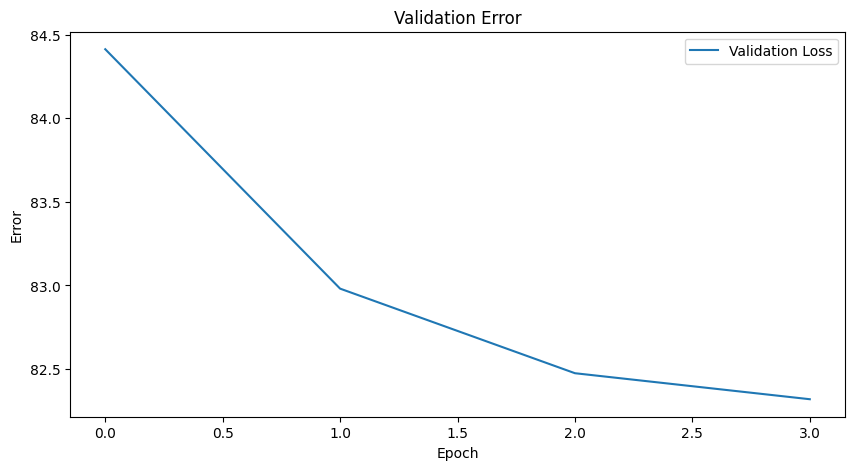

<Figure size 640x480 with 0 Axes>

In [ ]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_cnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('validation_error_model_rnn.png')  # This will save the plot as an image

## Experiment 3 (With Pooling)

In [ ]:
# We're scaling the model size so let's bring in more data as well
train_size = int(0.95 * total_size)
val_size = int(total_size * 0.04)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)

# Reload the data with particular batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
NUM_EPOCHS = 4
d_out = len(vocab.id_to_move.keys())
model = ChessCNN_pooling(d_out) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 2e-3
weight_decay=0
learn_decay = 0.5
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1635240
1074042


Epoch 1, Batch: 1000| Training Loss: 5.395469004154205
Epoch 1, Batch: 2000| Training Loss: 5.176014692306518
Epoch 1, Batch: 3000| Training Loss: 5.054431374867757
Epoch 1, Batch: 4000| Training Loss: 4.967140330851078
Epoch 1, Batch: 5000| Training Loss: 4.894964256715775
Epoch 1, Batch: 6000| Training Loss: 4.841230786164601
Epoch 1, Batch: 7000| Training Loss: 4.801570115123476
Epoch 1, Batch: 8000| Training Loss: 4.764032576084137
Epoch 1, Batch: 9000| Training Loss: 4.736011730114619
Epoch 1, Batch: 10000| Training Loss: 4.710235009169579
Epoch 1, Batch: 11000| Training Loss: 4.687637357690117
Epoch 1, Batch: 12000| Training Loss: 4.666666848977407
Epoch 1, Batch: 13000| Training Loss: 4.647181960674432
Epoch 1, Batch: 14000| Training Loss: 4.629871247087206
Epoch 1, Batch: 15000| Training Loss: 4.613379649241765
Epoch 1, Batch: 16000| Training Loss: 4.598858271881938
Epoch 1, Batch: 17000| Training Loss: 4.584812736595378
Epoch 1, Batch: 18000| Training Loss: 4.572868263747957
E

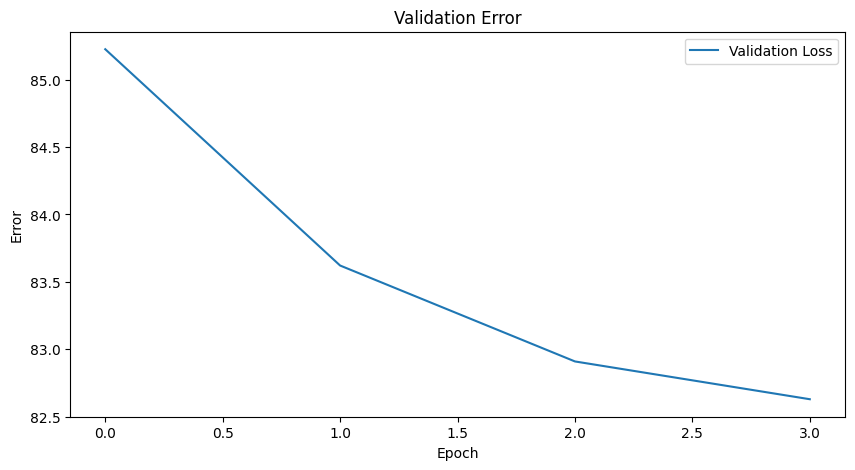

<Figure size 640x480 with 0 Axes>

In [ ]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_cnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('validation_error_model_rnn.png')  # This will save the plot as an image

## Experiment 4 (Dense Architecture)

In [ ]:
# We're scaling the model size so let's bring in more data as well
train_size = int(0.95 * total_size)
val_size = int(total_size * 0.04)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)

# Reload the data with particular batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
NUM_EPOCHS = 10
d_out = len(vocab.id_to_move.keys())
model = DenseNetEncoder(d_out) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 2e-3
weight_decay=0
learn_decay = 0.5
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1635240
769450


Epoch 1, Batch: 1000| Training Loss: 5.495953320503235
Epoch 1, Batch: 2000| Training Loss: 5.323993716239929
Epoch 1, Batch: 3000| Training Loss: 5.214595885833105
Epoch 1, Batch: 4000| Training Loss: 5.121598199903965
Epoch 1, Batch: 5000| Training Loss: 5.035450867795944
Epoch 1, Batch: 6000| Training Loss: 4.96518195784092
Epoch 1, Batch: 7000| Training Loss: 4.907126547166279
Epoch 1, Batch: 8000| Training Loss: 4.851445156514645
Epoch 1, Batch: 9000| Training Loss: 4.806792579703861
Epoch 1, Batch: 10000| Training Loss: 4.765358306407928
Epoch 1, Batch: 11000| Training Loss: 4.726995722900737
Epoch 1, Batch: 12000| Training Loss: 4.691529249747594
Epoch 1, Batch: 13000| Training Loss: 4.658310576328865
Epoch 1, Batch: 14000| Training Loss: 4.628354511260986
Epoch 1, Batch: 15000| Training Loss: 4.599925049559276
Epoch 1, Batch: 16000| Training Loss: 4.5737392834723
Epoch 1, Batch: 17000| Training Loss: 4.548864794787239
Epoch 1, Batch: 18000| Training Loss: 4.5261280860768425
Epo

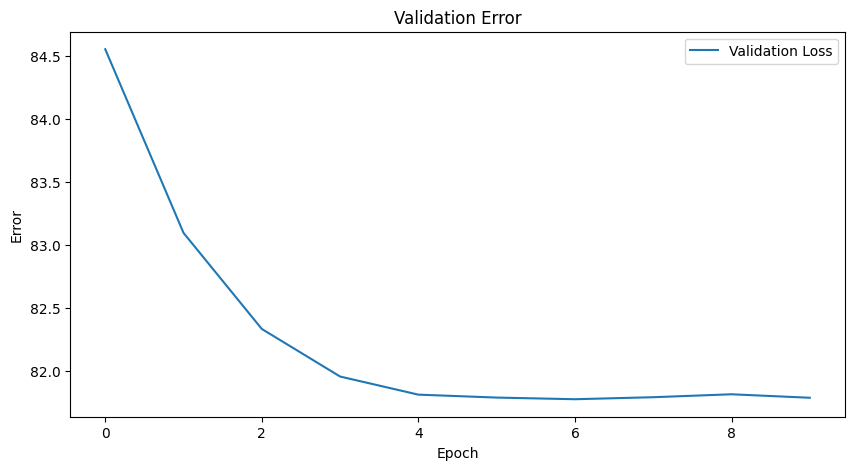

<Figure size 640x480 with 0 Axes>

In [ ]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_cnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('validation_error_model_rnn.png')  # This will save the plot as an image

## Experiment 5 (12 channels)


In [16]:
# Reload the data with particular batch size
torch.multiprocessing.set_start_method('fork', force=True)
batch_size = 64
# Shuffling... (False gives us )
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2,pin_memory=True)

# Initialize model, loss function, and optimizer
NUM_EPOCHS = 5
d_out = len(vocab.id_to_move.keys())
model = ChessCNN_no_pooling(d_out) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 2e-3
weight_decay=0
learn_decay = 0.5
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1596749


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 1, Batch: 1000| Training Loss: 5.3230355882644655
Epoch 1, Batch: 2000| Training Loss: 5.0432078551054005
Epoch 1, Batch: 3000| Training Loss: 4.881313978592555
Epoch 1, Batch: 4000| Training Loss: 4.77512623155117
Epoch 1, Batch: 5000| Training Loss: 4.695005063199997
Epoch 1, Batch: 6000| Training Loss: 4.63308141207695
Epoch 1, Batch: 7000| Training Loss: 4.580868843010494
Epoch 1, Batch: 8000| Training Loss: 4.537749739855528
Epoch 1, Batch: 9000| Training Loss: 4.502049186441633
Epoch 1, Batch: 10000| Training Loss: 4.471575670433045
Epoch 1, Batch: 11000| Training Loss: 4.443449655879627
Epoch 1, Batch: 12000| Training Loss: 4.4186740285754205
Epoch 1, Batch: 13000| Training Loss: 4.395960050913004
Epoch 1, Batch: 14000| Training Loss: 4.3763341557979585
Epoch 1, Batch: 15000| Training Loss: 4.3588509413878125
Epoch 1, Batch: 16000| Training Loss: 4.343105953812599
Epoch 1, Batch: 17000| Training Loss: 4.329248705232844
Epoch 1, Batch: 18000| Training Loss: 4.31683925441900

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 1, Training Loss: 4.132663186646649, Validation Error: 82.39620266701766, Validation Top-3 Accuracy: 34.14144571758248, Training Error: 83.54203130071177


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 2, Batch: 1000| Training Loss: 3.866259611129761
Epoch 2, Batch: 2000| Training Loss: 3.8684986069202423
Epoch 2, Batch: 3000| Training Loss: 3.8614338840643563
Epoch 2, Batch: 4000| Training Loss: 3.860898588478565
Epoch 2, Batch: 5000| Training Loss: 3.8592138722419738
Epoch 2, Batch: 6000| Training Loss: 3.8539484158356982
Epoch 2, Batch: 7000| Training Loss: 3.8528731610774996
Epoch 2, Batch: 8000| Training Loss: 3.8520373948812483
Epoch 2, Batch: 9000| Training Loss: 3.850811701456706
Epoch 2, Batch: 10000| Training Loss: 3.849034607696533
Epoch 2, Batch: 11000| Training Loss: 3.8484633780392734
Epoch 2, Batch: 12000| Training Loss: 3.8463429005940757
Epoch 2, Batch: 13000| Training Loss: 3.8449631921144634
Epoch 2, Batch: 14000| Training Loss: 3.8443610996178217
Epoch 2, Batch: 15000| Training Loss: 3.8431120027542116
Epoch 2, Batch: 16000| Training Loss: 3.8424592102468016
Epoch 2, Batch: 17000| Training Loss: 3.8420810128520517
Epoch 2, Batch: 18000| Training Loss: 3.8408

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 2, Training Loss: 3.8234425710960545, Validation Error: 81.27987232537286, Validation Top-3 Accuracy: 36.216981054332535, Training Error: 81.24021701217204


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 3, Batch: 1000| Training Loss: 3.704279134273529
Epoch 3, Batch: 2000| Training Loss: 3.7134467986822126
Epoch 3, Batch: 3000| Training Loss: 3.7156948460737866
Epoch 3, Batch: 4000| Training Loss: 3.716224045932293
Epoch 3, Batch: 5000| Training Loss: 3.7158610558032987
Epoch 3, Batch: 6000| Training Loss: 3.7147421604394912
Epoch 3, Batch: 7000| Training Loss: 3.71412761592865
Epoch 3, Batch: 8000| Training Loss: 3.7141640707552432
Epoch 3, Batch: 9000| Training Loss: 3.715638017813365
Epoch 3, Batch: 10000| Training Loss: 3.7144887726306917
Epoch 3, Batch: 11000| Training Loss: 3.7152404242862356
Epoch 3, Batch: 12000| Training Loss: 3.7138407209912936
Epoch 3, Batch: 13000| Training Loss: 3.7134426943522234
Epoch 3, Batch: 14000| Training Loss: 3.712926781807627
Epoch 3, Batch: 15000| Training Loss: 3.7131372130552927
Epoch 3, Batch: 16000| Training Loss: 3.712661930933595
Epoch 3, Batch: 17000| Training Loss: 3.7122827474930706
Epoch 3, Batch: 18000| Training Loss: 3.7126090

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 3, Training Loss: 3.7083492538348133, Validation Error: 80.32560320502802, Validation Top-3 Accuracy: 37.56118428100676, Training Error: 80.26187493223998


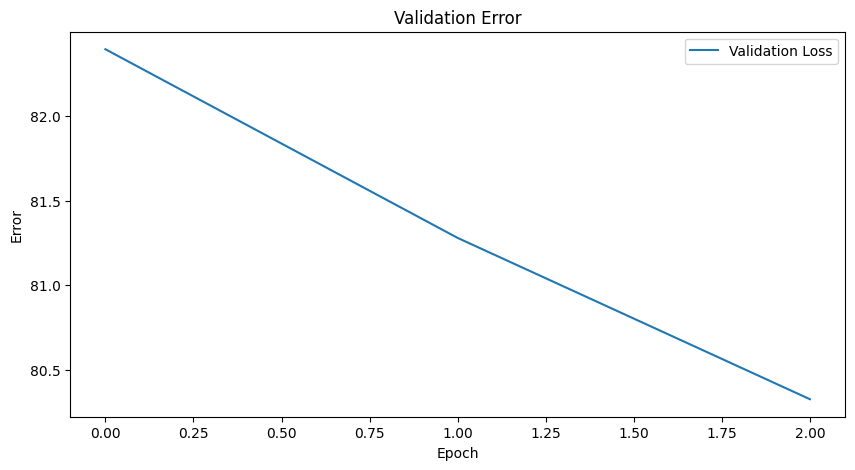

<Figure size 640x480 with 0 Axes>

In [17]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_cnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('validation_error_model_rnn.png')  # This will save the plot as an image

R . B Q . B . R
P P P . . K P P
. . N . . . . .
. . . N P . . .
. . b . . . . .
. . . . . . . .
p p p p . p p p
r n b q k . . r
Ke8
Ke6


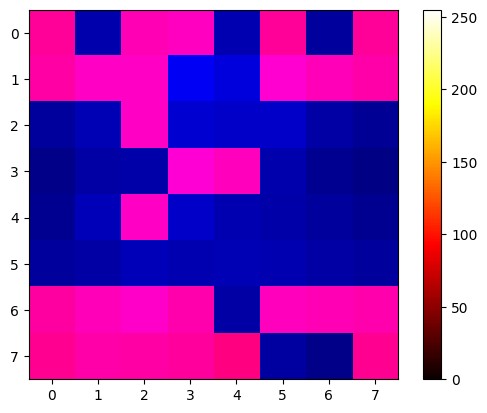


---------------------

R . B Q . B . R
P P P . . K P P
. . N . . . . .
. . . N P . . .
. . b . . . . .
. . . . . . . .
p p p p . p p p
r n b q k . . r
Qxd5
c6


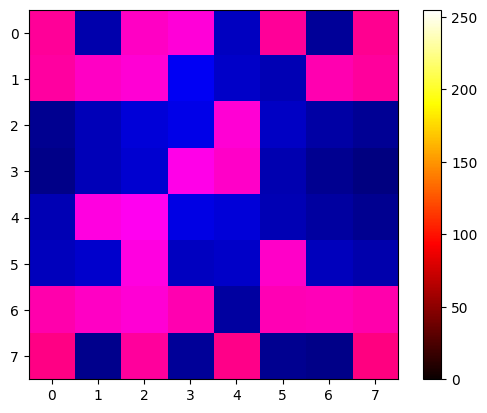


---------------------

R . B Q . B . R
P P P . . . P P
. . . . K . . .
. . . N P . . .
. N b . . . . .
. . n . . q . .
p p p p . p p p
r . b . k . . r
Qxd5
b5


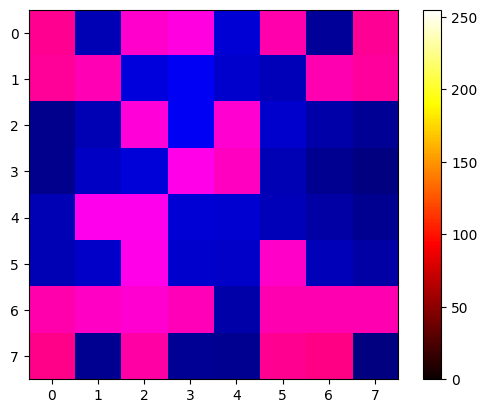


---------------------

R . B Q . B . R
P P . . . . P P
. . P . K . . .
. . . N P . . .
. N b . . . . .
. . n . . q . .
p p p p . p p p
r . b . . r k .
Nxc6
Qf6


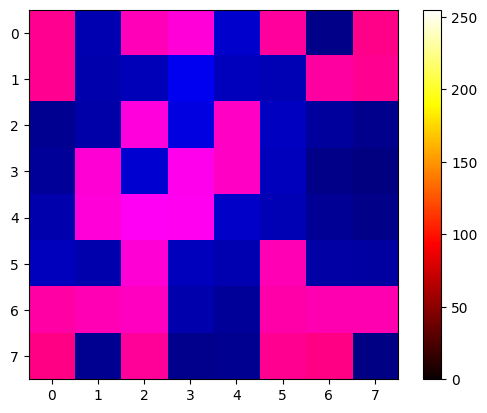


---------------------

R . B Q . B . R
P . . . . . P P
. . P . K . . .
. P . N P . . .
. N b p . . . .
. . n . . q . .
p p p . . p p p
r . b . . r k .
gxf6
gxf6


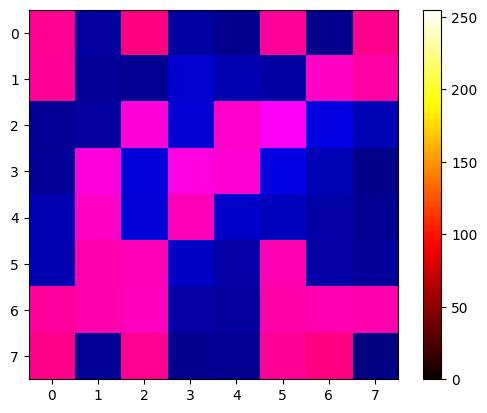


---------------------

R . B . . B . R
P . . . . . P P
. . P . K Q . .
. P . N P . . .
. N . p . . . .
. b n . . q . .
p p p . . p p p
r . b . . r k .
fxe5
Kd6


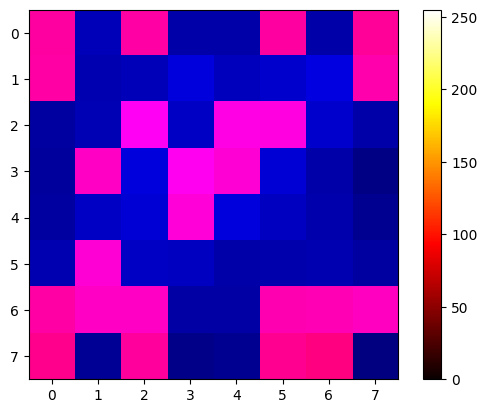


---------------------

R . B . . B . R
P . . . . . . P
. . P . K P . .
. P . N P . . .
. . . p . . . .
. b . . . . . .
p p p . . p p p
r . b . . r k .
e5
e5


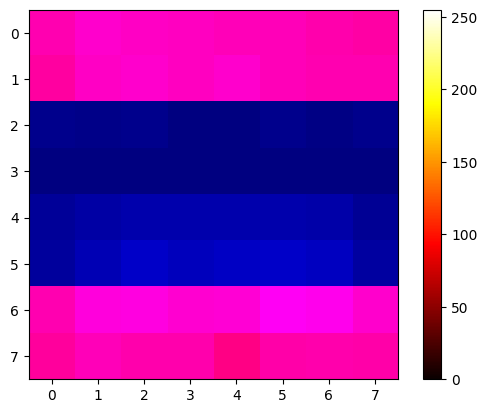


---------------------

R N B Q K B N R
P P P P P P P P
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
p p p p p p p p
r n b q k b n r
Nf6
Nf6


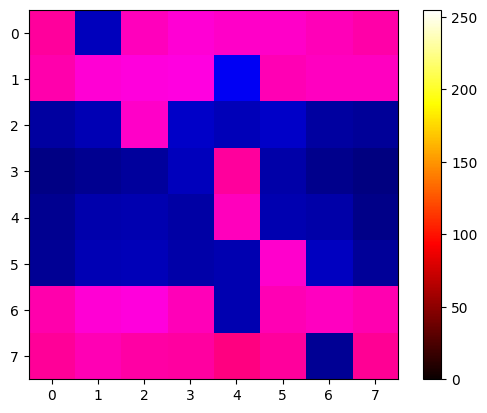


---------------------

R . B Q K B N R
P P P P . P P P
. . N . . . . .
. . . . P . . .
. . . . p . . .
. . . . . n . .
p p p p . p p p
r n b q k b . r
dxc6
dxc6


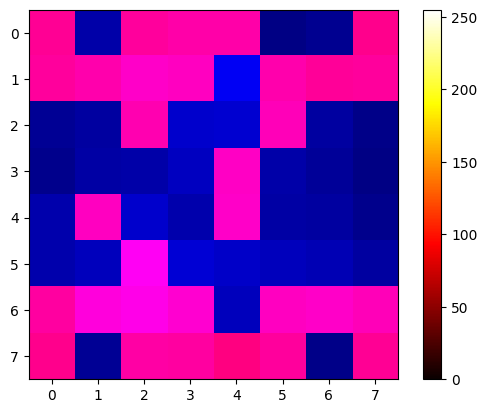


---------------------



In [ ]:

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

show_maps_on_training_data(model, train_loader)

In [ ]:
torch.save(model.state_dict(), 'cnnmodel.pth')

## Experiment 7 (17 channels, UCI vs SAN vs small cnn)

In [8]:
# Reload the data with particular batch size
torch.multiprocessing.set_start_method('fork', force=True)
batch_size = 64
# Shuffling... (False gives us )
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2,pin_memory=True)

# Initialize model, loss function, and optimizer
NUM_EPOCHS = 7
d_out = len(vocab.id_to_move.keys())
# d_out = 1968
model = SENetPure(d_out) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 2e-4
weight_decay=0
learn_decay = 0.1
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

4035866


In [9]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_cnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 1, Batch: 1000| Training Loss: 5.555908417224884
Epoch 1, Batch: 2000| Training Loss: 5.22413030552864
Epoch 1, Batch: 3000| Training Loss: 5.019992128690084
Epoch 1, Batch: 4000| Training Loss: 4.870226920843124
Epoch 1, Batch: 5000| Training Loss: 4.7538496837615964
Epoch 1, Batch: 6000| Training Loss: 4.659843733708064
Epoch 1, Batch: 7000| Training Loss: 4.577907100166593
Epoch 1, Batch: 8000| Training Loss: 4.5110527606606485
Epoch 1, Batch: 9000| Training Loss: 4.4515405385229325
Epoch 1, Batch: 10000| Training Loss: 4.399301040530204
Epoch 1, Batch: 11000| Training Loss: 4.352926912481134
Epoch 1, Batch: 12000| Training Loss: 4.311125482479731
Epoch 1, Batch: 13000| Training Loss: 4.272176778848355
Epoch 1, Batch: 14000| Training Loss: 4.236758277024542
Epoch 1, Batch: 15000| Training Loss: 4.20495356168747
Epoch 1, Batch: 16000| Training Loss: 4.174417033791542
Epoch 1, Batch: 17000| Training Loss: 4.146327296285068
Epoch 1, Batch: 18000| Training Loss: 4.120001093612776


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 1, Training Loss: 3.8278044864053964, Validation Error: 80.17441860465117, Validation Top-3 Accuracy: 39.38330564784053, Training Error: 82.4978690083386


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 2, Batch: 1000| Training Loss: 3.3384898188114165
Epoch 2, Batch: 2000| Training Loss: 3.334805949687958
Epoch 2, Batch: 3000| Training Loss: 3.332273911555608
Epoch 2, Batch: 4000| Training Loss: 3.3369795196056367
Epoch 2, Batch: 5000| Training Loss: 3.3374285160064696
Epoch 2, Batch: 6000| Training Loss: 3.3387122945785523
Epoch 2, Batch: 7000| Training Loss: 3.338819973264422
Epoch 2, Batch: 8000| Training Loss: 3.3375119844973087
Epoch 2, Batch: 9000| Training Loss: 3.3373801890744104
Epoch 2, Batch: 10000| Training Loss: 3.33650313706398
Epoch 2, Batch: 11000| Training Loss: 3.336023823174563
Epoch 2, Batch: 12000| Training Loss: 3.333764892935753
Epoch 2, Batch: 13000| Training Loss: 3.332724644129093
Epoch 2, Batch: 14000| Training Loss: 3.33182187468665
Epoch 2, Batch: 15000| Training Loss: 3.33136224638621
Epoch 2, Batch: 16000| Training Loss: 3.330609692081809
Epoch 2, Batch: 17000| Training Loss: 3.329437863125521
Epoch 2, Batch: 18000| Training Loss: 3.32835641176170

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 2, Training Loss: 3.3049282689915946, Validation Error: 79.01785714285714, Validation Top-3 Accuracy: 41.36420265780731, Training Error: 78.99340987350195


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 3, Batch: 1000| Training Loss: 3.1124183781147003
Epoch 3, Batch: 2000| Training Loss: 3.1200090897083284
Epoch 3, Batch: 3000| Training Loss: 3.124204547484716
Epoch 3, Batch: 4000| Training Loss: 3.126566074371338
Epoch 3, Batch: 5000| Training Loss: 3.13236244931221
Epoch 3, Batch: 6000| Training Loss: 3.1342746563355126
Epoch 3, Batch: 7000| Training Loss: 3.137376712185996
Epoch 3, Batch: 8000| Training Loss: 3.13958532717824
Epoch 3, Batch: 9000| Training Loss: 3.140656441317664
Epoch 3, Batch: 10000| Training Loss: 3.142129432296753
Epoch 3, Batch: 11000| Training Loss: 3.1433107621453025
Epoch 3, Batch: 12000| Training Loss: 3.1448842927416165
Epoch 3, Batch: 13000| Training Loss: 3.1454845932263593
Epoch 3, Batch: 14000| Training Loss: 3.1472262570858
Epoch 3, Batch: 15000| Training Loss: 3.1477427631378174
Epoch 3, Batch: 16000| Training Loss: 3.1486505518853662
Epoch 3, Batch: 17000| Training Loss: 3.1485761115831488
Epoch 3, Batch: 18000| Training Loss: 3.148909171038

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 3, Training Loss: 3.154040251986198, Validation Error: 78.85174418604652, Validation Top-3 Accuracy: 42.40033222591362, Training Error: 77.546904293108


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 4, Batch: 1000| Training Loss: 3.0102938163280486
Epoch 4, Batch: 2000| Training Loss: 3.013518312931061
Epoch 4, Batch: 3000| Training Loss: 3.0099025659561156
Epoch 4, Batch: 4000| Training Loss: 3.0115398957133293
Epoch 4, Batch: 5000| Training Loss: 3.016866055011749
Epoch 4, Batch: 6000| Training Loss: 3.0200917491515478
Epoch 4, Batch: 7000| Training Loss: 3.0249383791855404
Epoch 4, Batch: 8000| Training Loss: 3.0278383041918278
Epoch 4, Batch: 9000| Training Loss: 3.031153067774243
Epoch 4, Batch: 10000| Training Loss: 3.0323232938051223
Epoch 4, Batch: 11000| Training Loss: 3.0350020085031337
Epoch 4, Batch: 12000| Training Loss: 3.0372097690701483
Epoch 4, Batch: 13000| Training Loss: 3.0396591450251065
Epoch 4, Batch: 14000| Training Loss: 3.0411825529677525
Epoch 4, Batch: 15000| Training Loss: 3.0434579227924345
Epoch 4, Batch: 16000| Training Loss: 3.0449487341344357
Epoch 4, Batch: 17000| Training Loss: 3.0464893583830666
Epoch 4, Batch: 18000| Training Loss: 3.047

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 4, Training Loss: 3.0624780184302125, Validation Error: 78.29111295681064, Validation Top-3 Accuracy: 42.94019933554817, Training Error: 76.51092767386473


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 5, Batch: 1000| Training Loss: 2.917114366531372
Epoch 5, Batch: 2000| Training Loss: 2.921709358930588
Epoch 5, Batch: 3000| Training Loss: 2.931005130370458
Epoch 5, Batch: 4000| Training Loss: 2.936302604615688
Epoch 5, Batch: 5000| Training Loss: 2.94068866147995
Epoch 5, Batch: 6000| Training Loss: 2.9452525864044827
Epoch 5, Batch: 7000| Training Loss: 2.949400205544063
Epoch 5, Batch: 8000| Training Loss: 2.9521633331179618
Epoch 5, Batch: 9000| Training Loss: 2.956478682067659
Epoch 5, Batch: 10000| Training Loss: 2.9579405133247376
Epoch 5, Batch: 11000| Training Loss: 2.959559245781465
Epoch 5, Batch: 12000| Training Loss: 2.9624461404681206
Epoch 5, Batch: 13000| Training Loss: 2.963971561413545
Epoch 5, Batch: 14000| Training Loss: 2.9666407064710345
Epoch 5, Batch: 15000| Training Loss: 2.9691461730003357
Epoch 5, Batch: 16000| Training Loss: 2.971780002236366
Epoch 5, Batch: 17000| Training Loss: 2.972193154180751
Epoch 5, Batch: 18000| Training Loss: 2.974373308049

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 5, Training Loss: 2.996633970179251, Validation Error: 78.18521594684385, Validation Top-3 Accuracy: 43.064784053156146, Training Error: 75.71114755881044


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 6, Batch: 1000| Training Loss: 2.8654108233451843
Epoch 6, Batch: 2000| Training Loss: 2.874881624698639
Epoch 6, Batch: 3000| Training Loss: 2.8818773393630983
Epoch 6, Batch: 4000| Training Loss: 2.88737266767025
Epoch 6, Batch: 5000| Training Loss: 2.8923242115020753
Epoch 6, Batch: 6000| Training Loss: 2.894604256908099
Epoch 6, Batch: 7000| Training Loss: 2.8974396680082593
Epoch 6, Batch: 8000| Training Loss: 2.9001668028235437
Epoch 6, Batch: 9000| Training Loss: 2.9024918071428933
Epoch 6, Batch: 10000| Training Loss: 2.904274553132057
Epoch 6, Batch: 11000| Training Loss: 2.907151645226912
Epoch 6, Batch: 12000| Training Loss: 2.909499346077442
Epoch 6, Batch: 13000| Training Loss: 2.9116904054421644
Epoch 6, Batch: 14000| Training Loss: 2.9134133550269263
Epoch 6, Batch: 15000| Training Loss: 2.9159096927165984
Epoch 6, Batch: 16000| Training Loss: 2.9179942378401758
Epoch 6, Batch: 17000| Training Loss: 2.9201744704527015
Epoch 6, Batch: 18000| Training Loss: 2.9219303

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 6, Training Loss: 2.9459977791852014, Validation Error: 77.58098006644518, Validation Top-3 Accuracy: 43.57142857142857, Training Error: 75.03715053770347


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 7, Batch: 1000| Training Loss: 2.79655655169487
Epoch 7, Batch: 2000| Training Loss: 2.7821116725206374
Epoch 7, Batch: 3000| Training Loss: 2.771247026205063
Epoch 7, Batch: 4000| Training Loss: 2.763632990181446
Epoch 7, Batch: 5000| Training Loss: 2.7574493564128875
Epoch 7, Batch: 6000| Training Loss: 2.7522131584882734
Epoch 7, Batch: 7000| Training Loss: 2.7488756081376757
Epoch 7, Batch: 8000| Training Loss: 2.747425549656153
Epoch 7, Batch: 9000| Training Loss: 2.7461163969039917
Epoch 7, Batch: 10000| Training Loss: 2.7436861696720123
Epoch 7, Batch: 11000| Training Loss: 2.74052362816984
Epoch 7, Batch: 12000| Training Loss: 2.740094637175401
Epoch 7, Batch: 13000| Training Loss: 2.7390606053975914
Epoch 7, Batch: 14000| Training Loss: 2.7370393778596607
Epoch 7, Batch: 15000| Training Loss: 2.735241314570109
Epoch 7, Batch: 16000| Training Loss: 2.7339957004487516
Epoch 7, Batch: 17000| Training Loss: 2.732614959113738
Epoch 7, Batch: 18000| Training Loss: 2.7313514055

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 7, Training Loss: 2.7202349731418294, Validation Error: 76.76287375415282, Validation Top-3 Accuracy: 45.01038205980066, Training Error: 71.35947207063033


In [10]:
# Reload the data with particular batch size
torch.multiprocessing.set_start_method('fork', force=True)
batch_size = 64
# Shuffling... (False gives us )
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2,pin_memory=True)

# Initialize model, loss function, and optimizer
NUM_EPOCHS = 7
d_out = len(vocab.id_to_move.keys())
model = ChessCNN_no_pooling(d_out) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 2e-3
weight_decay=0
learn_decay = 0.5
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1907066


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 1, Batch: 1000| Training Loss: 5.731760203838348
Epoch 1, Batch: 2000| Training Loss: 5.465565154075622
Epoch 1, Batch: 3000| Training Loss: 5.303909942944845
Epoch 1, Batch: 4000| Training Loss: 5.19432707720995
Epoch 1, Batch: 5000| Training Loss: 5.107880146789551
Epoch 1, Batch: 6000| Training Loss: 5.040597863197327
Epoch 1, Batch: 7000| Training Loss: 4.985829377685274
Epoch 1, Batch: 8000| Training Loss: 4.936096258819103
Epoch 1, Batch: 9000| Training Loss: 4.897204505549537
Epoch 1, Batch: 10000| Training Loss: 4.862197125768661
Epoch 1, Batch: 11000| Training Loss: 4.831744701537219
Epoch 1, Batch: 12000| Training Loss: 4.805198590020339
Epoch 1, Batch: 13000| Training Loss: 4.780317434182534
Epoch 1, Batch: 14000| Training Loss: 4.75823472728048
Epoch 1, Batch: 15000| Training Loss: 4.738495447826385
Epoch 1, Batch: 16000| Training Loss: 4.721039522483945
Epoch 1, Batch: 17000| Training Loss: 4.7041402601775
Epoch 1, Batch: 18000| Training Loss: 4.689350567883915
Epoch

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 1, Training Loss: 4.524026962509906, Validation Error: 85.1827242524917, Validation Top-3 Accuracy: 28.855897009966778, Training Error: 86.19095997160676


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 2, Batch: 1000| Training Loss: 4.259375550985336
Epoch 2, Batch: 2000| Training Loss: 4.259532014727593
Epoch 2, Batch: 3000| Training Loss: 4.257004157304764
Epoch 2, Batch: 4000| Training Loss: 4.2602485626935955
Epoch 2, Batch: 5000| Training Loss: 4.260918134737015
Epoch 2, Batch: 6000| Training Loss: 4.260466303269069
Epoch 2, Batch: 7000| Training Loss: 4.259824808631625
Epoch 2, Batch: 8000| Training Loss: 4.260551810026169
Epoch 2, Batch: 9000| Training Loss: 4.259286941819721
Epoch 2, Batch: 10000| Training Loss: 4.2582312354803085
Epoch 2, Batch: 11000| Training Loss: 4.257262317180634
Epoch 2, Batch: 12000| Training Loss: 4.257975069562594
Epoch 2, Batch: 13000| Training Loss: 4.257326510190964
Epoch 2, Batch: 14000| Training Loss: 4.256703629221235
Epoch 2, Batch: 15000| Training Loss: 4.25714002310435
Epoch 2, Batch: 16000| Training Loss: 4.2582968580126765
Epoch 2, Batch: 17000| Training Loss: 4.25829534443687
Epoch 2, Batch: 18000| Training Loss: 4.257979616377089


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 2, Training Loss: 4.248346394825188, Validation Error: 84.92109634551495, Validation Top-3 Accuracy: 29.526578073089702, Training Error: 84.67150190922297


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 3, Batch: 1000| Training Loss: 4.192645314693451
Epoch 3, Batch: 2000| Training Loss: 4.192729214787483
Epoch 3, Batch: 3000| Training Loss: 4.185393471717834
Epoch 3, Batch: 4000| Training Loss: 4.184386851966381
Epoch 3, Batch: 5000| Training Loss: 4.1857132057189945
Epoch 3, Batch: 6000| Training Loss: 4.187486834843954
Epoch 3, Batch: 7000| Training Loss: 4.188149032626833
Epoch 3, Batch: 8000| Training Loss: 4.188098440468312
Epoch 3, Batch: 9000| Training Loss: 4.189644107050366
Epoch 3, Batch: 10000| Training Loss: 4.190092603397369
Epoch 3, Batch: 11000| Training Loss: 4.191334857767279
Epoch 3, Batch: 12000| Training Loss: 4.191360808650653
Epoch 3, Batch: 13000| Training Loss: 4.190780595485981
Epoch 3, Batch: 14000| Training Loss: 4.189761320131166
Epoch 3, Batch: 15000| Training Loss: 4.189811998049418
Epoch 3, Batch: 16000| Training Loss: 4.189788661435246
Epoch 3, Batch: 17000| Training Loss: 4.189392636369257
Epoch 3, Batch: 18000| Training Loss: 4.189867688099543


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 3, Training Loss: 4.19308030196705, Validation Error: 84.74252491694352, Validation Top-3 Accuracy: 29.78405315614618, Training Error: 84.41895103407147


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 4, Batch: 1000| Training Loss: 4.127896209955216
Epoch 4, Batch: 2000| Training Loss: 4.141476933360099
Epoch 4, Batch: 3000| Training Loss: 4.150647231419881
Epoch 4, Batch: 4000| Training Loss: 4.156712039709091
Epoch 4, Batch: 5000| Training Loss: 4.156704153585434
Epoch 4, Batch: 6000| Training Loss: 4.156173463185628
Epoch 4, Batch: 7000| Training Loss: 4.155269379581724
Epoch 4, Batch: 8000| Training Loss: 4.1569809782803055
Epoch 4, Batch: 9000| Training Loss: 4.157571321911282
Epoch 4, Batch: 10000| Training Loss: 4.157745860981941
Epoch 4, Batch: 11000| Training Loss: 4.16089477148923
Epoch 4, Batch: 12000| Training Loss: 4.161505227108797
Epoch 4, Batch: 13000| Training Loss: 4.161279138051547
Epoch 4, Batch: 14000| Training Loss: 4.1620354383502685
Epoch 4, Batch: 15000| Training Loss: 4.163632479731242
Epoch 4, Batch: 16000| Training Loss: 4.16384824039042
Epoch 4, Batch: 17000| Training Loss: 4.164052678865545
Epoch 4, Batch: 18000| Training Loss: 4.164137491928207
E

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 4, Training Loss: 4.166706392078278, Validation Error: 84.88579734219269, Validation Top-3 Accuracy: 29.858803986710964, Training Error: 84.33157074314347


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 5, Batch: 1000| Training Loss: 4.13873836183548
Epoch 5, Batch: 2000| Training Loss: 4.140764969825745
Epoch 5, Batch: 3000| Training Loss: 4.14123325753212
Epoch 5, Batch: 4000| Training Loss: 4.141025268137455
Epoch 5, Batch: 5000| Training Loss: 4.142640737819671
Epoch 5, Batch: 6000| Training Loss: 4.1431149960358935
Epoch 5, Batch: 7000| Training Loss: 4.146169488702501
Epoch 5, Batch: 8000| Training Loss: 4.14555288463831
Epoch 5, Batch: 9000| Training Loss: 4.143532388369242
Epoch 5, Batch: 10000| Training Loss: 4.143032902312279
Epoch 5, Batch: 11000| Training Loss: 4.143337776119059
Epoch 5, Batch: 12000| Training Loss: 4.144656288345655
Epoch 5, Batch: 13000| Training Loss: 4.1451477982447695
Epoch 5, Batch: 14000| Training Loss: 4.146118687953268
Epoch 5, Batch: 15000| Training Loss: 4.148283382733663
Epoch 5, Batch: 16000| Training Loss: 4.149324972257018
Epoch 5, Batch: 17000| Training Loss: 4.149512633912703
Epoch 5, Batch: 18000| Training Loss: 4.150048509664006
Ep

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 5, Training Loss: 4.160129104172866, Validation Error: 84.73629568106313, Validation Top-3 Accuracy: 29.364617940199334, Training Error: 84.37947791881639


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 6, Batch: 1000| Training Loss: 4.132289508342743
Epoch 6, Batch: 2000| Training Loss: 4.12307117664814
Epoch 6, Batch: 3000| Training Loss: 4.126389493942261
Epoch 6, Batch: 4000| Training Loss: 4.126427725315094
Epoch 6, Batch: 5000| Training Loss: 4.130082797193527
Epoch 6, Batch: 6000| Training Loss: 4.134762712796529
Epoch 6, Batch: 7000| Training Loss: 4.138287211179733
Epoch 6, Batch: 8000| Training Loss: 4.140310086071492
Epoch 6, Batch: 9000| Training Loss: 4.1411926798820495
Epoch 6, Batch: 10000| Training Loss: 4.1425693047523495
Epoch 6, Batch: 11000| Training Loss: 4.141535368420861
Epoch 6, Batch: 12000| Training Loss: 4.14068912901481
Epoch 6, Batch: 13000| Training Loss: 4.1416841488618115
Epoch 6, Batch: 14000| Training Loss: 4.143414177264486
Epoch 6, Batch: 15000| Training Loss: 4.143321399354934
Epoch 6, Batch: 16000| Training Loss: 4.144625775128603
Epoch 6, Batch: 17000| Training Loss: 4.144913285017013
Epoch 6, Batch: 18000| Training Loss: 4.145470510972871


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 6, Training Loss: 4.151989492895924, Validation Error: 84.7217607973422, Validation Top-3 Accuracy: 30.74127906976744, Training Error: 84.3385919914101


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 7, Batch: 1000| Training Loss: 4.0653575208187105
Epoch 7, Batch: 2000| Training Loss: 4.0713218729496
Epoch 7, Batch: 3000| Training Loss: 4.064889014085134
Epoch 7, Batch: 4000| Training Loss: 4.062433782041073
Epoch 7, Batch: 5000| Training Loss: 4.063486024188995
Epoch 7, Batch: 6000| Training Loss: 4.063038270155589
Epoch 7, Batch: 7000| Training Loss: 4.060364005190985
Epoch 7, Batch: 8000| Training Loss: 4.059947255671024
Epoch 7, Batch: 9000| Training Loss: 4.059505010181003
Epoch 7, Batch: 10000| Training Loss: 4.059121199440956
Epoch 7, Batch: 11000| Training Loss: 4.057849510604685
Epoch 7, Batch: 12000| Training Loss: 4.057743451019128
Epoch 7, Batch: 13000| Training Loss: 4.056141182532677
Epoch 7, Batch: 14000| Training Loss: 4.056428356375013
Epoch 7, Batch: 15000| Training Loss: 4.056434633493423
Epoch 7, Batch: 16000| Training Loss: 4.05548011572659
Epoch 7, Batch: 17000| Training Loss: 4.0551539984029885
Epoch 7, Batch: 18000| Training Loss: 4.055124719222387
Ep

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 7, Training Loss: 4.052746915698369, Validation Error: 83.73961794019934, Validation Top-3 Accuracy: 31.40988372093023, Training Error: 83.52669594184694


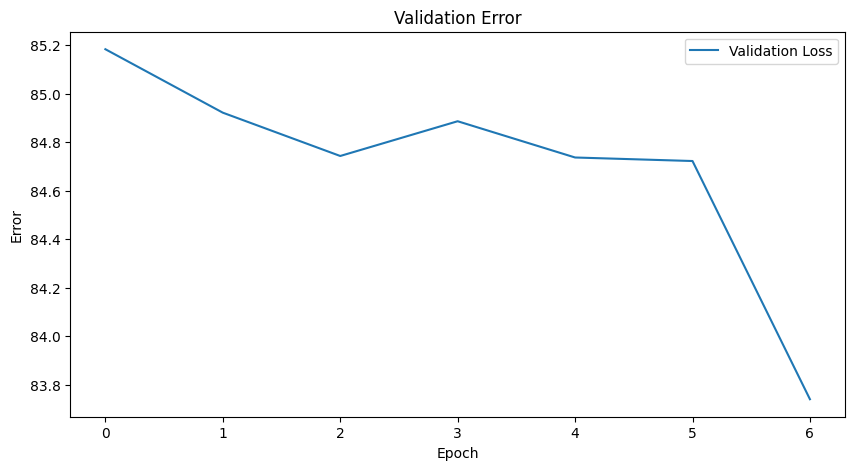

<Figure size 640x480 with 0 Axes>

In [11]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_cnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('validation_error_model_rnn.png')  # This will save the plot as an image

Let's do it again but now with UCI notation data

In [12]:
trainX, fens, trainY, vocab = df_to_data_board_only(grouped_df, sampling_rate=0.1, algebraic_notation = False)

In [266]:
print(len(fens))

672639


In [272]:
print(len(vocab.id_to_move.keys()))

1907


In [13]:
dataset = CNNDataset(trainX, fens, trainY)
# Calculate split sizes
total_size = len(dataset)
print(total_size)
train_size = int(0.97 * total_size)
val_size = int(total_size * 0.02)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)

2512893
2437506


In [269]:
batch_size = 64
# Shuffling... (False gives us )
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2,pin_memory=True)


In [14]:
# Reload the data with particular batch size
torch.multiprocessing.set_start_method('fork', force=True)
batch_size = 64
# Shuffling... (False gives us )
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2,pin_memory=True)

# Initialize model, loss function, and optimizer
NUM_EPOCHS = 7
#d_out = len(vocab.id_to_move.keys())
d_out = 1968
model = SENetPure(d_out) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 2e-5
weight_decay=0
learn_decay = 0.1
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1839544


In [15]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_cnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 1, Batch: 1000| Training Loss: 6.275036812782288
Epoch 1, Batch: 2000| Training Loss: 5.988965579986572
Epoch 1, Batch: 3000| Training Loss: 5.839550039132436
Epoch 1, Batch: 4000| Training Loss: 5.738987903952599
Epoch 1, Batch: 5000| Training Loss: 5.659568845558167
Epoch 1, Batch: 6000| Training Loss: 5.590299972216288
Epoch 1, Batch: 7000| Training Loss: 5.530588520595005
Epoch 1, Batch: 8000| Training Loss: 5.478657355606556
Epoch 1, Batch: 9000| Training Loss: 5.430611639552646
Epoch 1, Batch: 10000| Training Loss: 5.3856294692993165
Epoch 1, Batch: 11000| Training Loss: 5.342656953681599
Epoch 1, Batch: 12000| Training Loss: 5.301076302468776
Epoch 1, Batch: 13000| Training Loss: 5.261459130140452
Epoch 1, Batch: 14000| Training Loss: 5.222181488360677
Epoch 1, Batch: 15000| Training Loss: 5.185103046210607
Epoch 1, Batch: 16000| Training Loss: 5.148670422166586
Epoch 1, Batch: 17000| Training Loss: 5.112482665188172
Epoch 1, Batch: 18000| Training Loss: 5.077357604821523


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 1, Training Loss: 4.5513237560869255, Validation Error: 84.19125693933184, Validation Top-3 Accuracy: 31.474222496427966, Training Error: 86.14284436633181


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 2, Batch: 1000| Training Loss: 3.806024845600128
Epoch 2, Batch: 2000| Training Loss: 3.7974763095378874
Epoch 2, Batch: 3000| Training Loss: 3.790282838424047
Epoch 2, Batch: 4000| Training Loss: 3.7855704661011695
Epoch 2, Batch: 5000| Training Loss: 3.7802773590087893
Epoch 2, Batch: 6000| Training Loss: 3.7727118177811305
Epoch 2, Batch: 7000| Training Loss: 3.767138929094587
Epoch 2, Batch: 8000| Training Loss: 3.7604413770139216
Epoch 2, Batch: 9000| Training Loss: 3.7548039840857186
Epoch 2, Batch: 10000| Training Loss: 3.7496449693202973
Epoch 2, Batch: 11000| Training Loss: 3.7437567483945324
Epoch 2, Batch: 12000| Training Loss: 3.738505563477675
Epoch 2, Batch: 13000| Training Loss: 3.734236863191311
Epoch 2, Batch: 14000| Training Loss: 3.7299677956785473
Epoch 2, Batch: 15000| Training Loss: 3.726015834267934
Epoch 2, Batch: 16000| Training Loss: 3.723410372197628
Epoch 2, Batch: 17000| Training Loss: 3.719703231264563
Epoch 2, Batch: 18000| Training Loss: 3.71561615

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 2, Training Loss: 3.649939461423196, Validation Error: 82.6153570646875, Validation Top-3 Accuracy: 34.39122908269377, Training Error: 83.01193925266236


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 3, Batch: 1000| Training Loss: 3.483020756006241
Epoch 3, Batch: 2000| Training Loss: 3.479381079912186
Epoch 3, Batch: 3000| Training Loss: 3.4820828687349956
Epoch 3, Batch: 4000| Training Loss: 3.483744958162308
Epoch 3, Batch: 5000| Training Loss: 3.4802700422763824
Epoch 3, Batch: 6000| Training Loss: 3.4806341499884925
Epoch 3, Batch: 7000| Training Loss: 3.4796304031780787
Epoch 3, Batch: 8000| Training Loss: 3.4787274623811246
Epoch 3, Batch: 9000| Training Loss: 3.476125892003377
Epoch 3, Batch: 10000| Training Loss: 3.475601124191284
Epoch 3, Batch: 11000| Training Loss: 3.4740573950464073
Epoch 3, Batch: 12000| Training Loss: 3.4737265084783235
Epoch 3, Batch: 13000| Training Loss: 3.4717889229884515
Epoch 3, Batch: 14000| Training Loss: 3.471052893093654
Epoch 3, Batch: 15000| Training Loss: 3.470204947121938
Epoch 3, Batch: 16000| Training Loss: 3.468310795292258
Epoch 3, Batch: 17000| Training Loss: 3.467836736468708
Epoch 3, Batch: 18000| Training Loss: 3.466522122

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 3, Training Loss: 3.4431631164401546, Validation Error: 81.6304196430348, Validation Top-3 Accuracy: 36.2456971168492, Training Error: 81.50478398822403


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 4, Batch: 1000| Training Loss: 3.339806299686432
Epoch 4, Batch: 2000| Training Loss: 3.338694095849991
Epoch 4, Batch: 3000| Training Loss: 3.341699094295502
Epoch 4, Batch: 4000| Training Loss: 3.340814384698868
Epoch 4, Batch: 5000| Training Loss: 3.341226714849472
Epoch 4, Batch: 6000| Training Loss: 3.3434454770088196
Epoch 4, Batch: 7000| Training Loss: 3.34455114872115
Epoch 4, Batch: 8000| Training Loss: 3.3452849054038523
Epoch 4, Batch: 9000| Training Loss: 3.3455745278729334
Epoch 4, Batch: 10000| Training Loss: 3.3457052090168
Epoch 4, Batch: 11000| Training Loss: 3.345064857829701
Epoch 4, Batch: 12000| Training Loss: 3.3450398774345715
Epoch 4, Batch: 13000| Training Loss: 3.3453560741314523
Epoch 4, Batch: 14000| Training Loss: 3.3450122690882003
Epoch 4, Batch: 15000| Training Loss: 3.344306777381897
Epoch 4, Batch: 16000| Training Loss: 3.3436787827908994
Epoch 4, Batch: 17000| Training Loss: 3.3432919257388396
Epoch 4, Batch: 18000| Training Loss: 3.342787779794

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 4, Training Loss: 3.3321550422571504, Validation Error: 81.17874126987286, Validation Top-3 Accuracy: 37.08936068702238, Training Error: 80.43368918886765


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 5, Batch: 1000| Training Loss: 3.245949835062027
Epoch 5, Batch: 2000| Training Loss: 3.249369867682457
Epoch 5, Batch: 3000| Training Loss: 3.2492972424825033
Epoch 5, Batch: 4000| Training Loss: 3.2508434231877326
Epoch 5, Batch: 5000| Training Loss: 3.2528699383735655
Epoch 5, Batch: 6000| Training Loss: 3.2555687199433643
Epoch 5, Batch: 7000| Training Loss: 3.257446357079915
Epoch 5, Batch: 8000| Training Loss: 3.257052214026451
Epoch 5, Batch: 9000| Training Loss: 3.255994214428796
Epoch 5, Batch: 10000| Training Loss: 3.256655662846565
Epoch 5, Batch: 11000| Training Loss: 3.256622040206736
Epoch 5, Batch: 12000| Training Loss: 3.2563561497926714
Epoch 5, Batch: 13000| Training Loss: 3.2566864491792824
Epoch 5, Batch: 14000| Training Loss: 3.2568439649002894
Epoch 5, Batch: 15000| Training Loss: 3.2567312603155774
Epoch 5, Batch: 16000| Training Loss: 3.2563820182979106
Epoch 5, Batch: 17000| Training Loss: 3.2565070103336784
Epoch 5, Batch: 18000| Training Loss: 3.2572296

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 5, Training Loss: 3.2568635338730605, Validation Error: 80.92604015361044, Validation Top-3 Accuracy: 37.79374017555724, Training Error: 79.64185524056145


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 6, Batch: 1000| Training Loss: 3.1994851686954497
Epoch 6, Batch: 2000| Training Loss: 3.191711835026741
Epoch 6, Batch: 3000| Training Loss: 3.192624636332194
Epoch 6, Batch: 4000| Training Loss: 3.189165085494518
Epoch 6, Batch: 5000| Training Loss: 3.193168361902237
Epoch 6, Batch: 6000| Training Loss: 3.1972622527281445
Epoch 6, Batch: 7000| Training Loss: 3.196317677225385
Epoch 6, Batch: 8000| Training Loss: 3.1978618890047072
Epoch 6, Batch: 9000| Training Loss: 3.19870164598359
Epoch 6, Batch: 10000| Training Loss: 3.2001349709510802
Epoch 6, Batch: 11000| Training Loss: 3.200426701979204
Epoch 6, Batch: 12000| Training Loss: 3.1995938737392424
Epoch 6, Batch: 13000| Training Loss: 3.2009890369268565
Epoch 6, Batch: 14000| Training Loss: 3.200186214549201
Epoch 6, Batch: 15000| Training Loss: 3.2000090947469078
Epoch 6, Batch: 16000| Training Loss: 3.1998954787552356
Epoch 6, Batch: 17000| Training Loss: 3.19951368504412
Epoch 6, Batch: 18000| Training Loss: 3.19927915943

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 6, Training Loss: 3.2001007882940344, Validation Error: 80.16594703225421, Validation Top-3 Accuracy: 38.60556738382595, Training Error: 78.95816461579992


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 7, Batch: 1000| Training Loss: 3.113136159181595
Epoch 7, Batch: 2000| Training Loss: 3.111195019602776
Epoch 7, Batch: 3000| Training Loss: 3.11060387468338
Epoch 7, Batch: 4000| Training Loss: 3.1085283906459806
Epoch 7, Batch: 5000| Training Loss: 3.1077675044536592
Epoch 7, Batch: 6000| Training Loss: 3.106524353504181
Epoch 7, Batch: 7000| Training Loss: 3.1069643381323133
Epoch 7, Batch: 8000| Training Loss: 3.105923375815153
Epoch 7, Batch: 9000| Training Loss: 3.107252013656828
Epoch 7, Batch: 10000| Training Loss: 3.1071287211179732
Epoch 7, Batch: 11000| Training Loss: 3.107652862743898
Epoch 7, Batch: 12000| Training Loss: 3.1071572810411454
Epoch 7, Batch: 13000| Training Loss: 3.107028820477999
Epoch 7, Batch: 14000| Training Loss: 3.106717122231211
Epoch 7, Batch: 15000| Training Loss: 3.1065824249108633
Epoch 7, Batch: 16000| Training Loss: 3.1056585669219494
Epoch 7, Batch: 17000| Training Loss: 3.105325102217057
Epoch 7, Batch: 18000| Training Loss: 3.10529546882

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 7, Training Loss: 3.1036568449184996, Validation Error: 79.71824820423026, Validation Top-3 Accuracy: 39.39351732168181, Training Error: 77.41572738692746


## Experiment 8 (Maia)

In [13]:
# Reload the data with particular batch size
torch.multiprocessing.set_start_method('fork', force=True)
batch_size = 64
# Shuffling... (False gives us )
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2,pin_memory=True)

# Initialize model, loss function, and optimizer
NUM_EPOCHS = 15
d_out = len(vocab.id_to_move.keys())
# d_out = 1968
model = SENetPureTwo(d_out) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 2e-4
weight_decay=0
learn_decay = 0.1
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

4269362


Epoch 1, Batch: 1000| Training Loss: 5.575244430541992
Epoch 1, Batch: 2000| Training Loss: 5.2513636342287064
Epoch 1, Batch: 3000| Training Loss: 5.05317520125707
Epoch 1, Batch: 4000| Training Loss: 4.910705524981022
Epoch 1, Batch: 5000| Training Loss: 4.796598896503449
Epoch 1, Batch: 6000| Training Loss: 4.706918999036153
Epoch 1, Batch: 7000| Training Loss: 4.628384713513511
Epoch 1, Batch: 8000| Training Loss: 4.563977998495102
Epoch 1, Batch: 9000| Training Loss: 4.505968973080317
Epoch 1, Batch: 10000| Training Loss: 4.454898725676537
Epoch 1, Batch: 11000| Training Loss: 4.4099489985379305
Epoch 1, Batch: 12000| Training Loss: 4.370176893810431
Epoch 1, Batch: 13000| Training Loss: 4.333369103028224
Epoch 1, Batch: 14000| Training Loss: 4.299699153423309
Epoch 1, Batch: 15000| Training Loss: 4.268291582107544
Epoch 1, Batch: 16000| Training Loss: 4.23970143455267
Epoch 1, Batch: 17000| Training Loss: 4.212995196019902
Epoch 1, Batch: 18000| Training Loss: 4.188542259375255
E

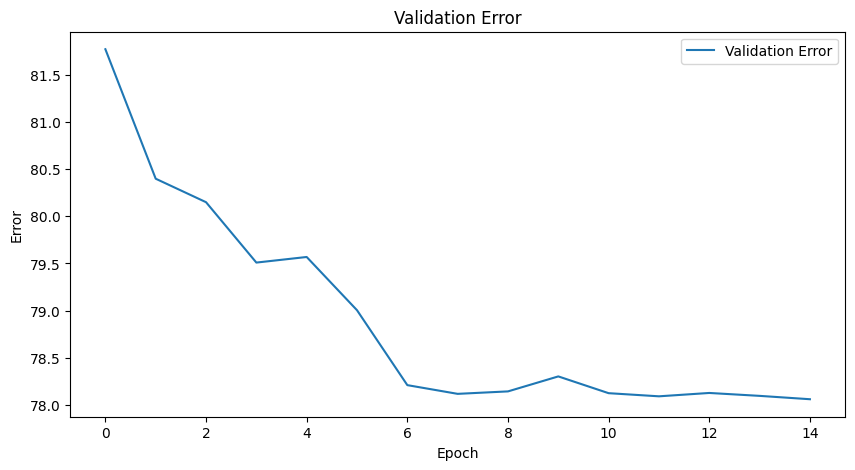

<Figure size 640x480 with 0 Axes>

In [15]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_cnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('cnn-4-24.png')  # This will save the plot as an image

In [14]:
len(vocab.id_to_move.keys())

10514

In [16]:
del trainX

In [7]:
def df_to_data_board_only_np(df, vocab, sampling_rate=1.0, algebraic_notation=True):
    if vocab is None: 
        vocab = VocabularyWithCLS()
    initial_size = 1000000  # Initial size of the arrays
    resize_factor = 2    # Factor by which to resize the arrays if needed
    board_states = np.empty((initial_size, 17,8 , 8), dtype=np.bool_)
    next_moves = np.empty(initial_size, dtype=int)
    fens = []
    chess_board = chess.Board()
    idx = 0  # Current index to insert data
    
    for game_board, game_moves in zip(df["board"], df["moves"]):
        moves = game_moves.split()
        boards = game_board.split("*")
        encoded_moves = []
        for move in moves:
            move_obj = chess.Move.from_uci(move)
            if algebraic_notation and (move_obj not in chess_board.legal_moves):
                break
            else:
                if algebraic_notation:
                    algebraic_move = chess_board.san(move_obj)
                    chess_board.push(move_obj)
                    vocab.add_move(algebraic_move)
                    encoded_move = vocab.get_id(algebraic_move)
                else:
                    vocab.add_move(move)
                    encoded_move = vocab.get_id(move)
                encoded_moves.append(encoded_move)
        if algebraic_notation:
            chess_board.reset()
        
        boards = boards[:len(encoded_moves)]
        for i in range(len(encoded_moves) - 1):
            if random.uniform(0, 1) <= sampling_rate:
                label = encoded_moves[i + 1]
                fens.append(boards[i])
                if idx >= board_states.shape[0]:  # Check if resize is needed
                    new_size = board_states.shape[0] * resize_factor
                    board_states = np.resize(board_states, (new_size, 17,8,8))
                    next_moves = np.resize(next_moves, new_size)
                board_states[idx] = fen_to_array_three(boards[i])
                next_moves[idx] = label
                idx += 1

    # Efficiently resize to the final size by creating new arrays
    board_states_final = np.array(board_states[:idx], dtype=np.bool_)
    next_moves_final = np.array(next_moves[:idx], dtype=int)

    del chess_board, board_states, next_moves  # Clean up original arrays
    return board_states_final, fens, next_moves_final, vocab

In [8]:
trainX, fens, trainY, vocab = df_to_data_board_only_np(grouped_df, None, sampling_rate=0.0875, algebraic_notation = False)

In [17]:
len(vocab.id_to_move.keys())

1946

In [16]:
dataset = CNNDataset(trainX, fens, trainY)
# Calculate split sizes
total_size = len(dataset)
print(total_size)
train_size = int(0.97 * total_size)
val_size = int(total_size * 0.02)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)

2199021
2133050


In [20]:
# Reload the data with particular batch size
torch.multiprocessing.set_start_method('fork', force=True)
batch_size = 64
# Shuffling... (False gives us )
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2,pin_memory=True)

# Initialize model, loss function, and optimizer
NUM_EPOCHS = 15
#d_out = len(vocab.id_to_move.keys())
d_out = 1968
model = SENetPureTwo(d_out) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 2e-4
weight_decay=0
learn_decay = 0.1
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

2073040


Epoch 1, Batch: 1000| Training Loss: 5.637044683456421
Epoch 1, Batch: 2000| Training Loss: 5.313734525680542
Epoch 1, Batch: 3000| Training Loss: 5.072034440994263
Epoch 1, Batch: 4000| Training Loss: 4.892069814920426
Epoch 1, Batch: 5000| Training Loss: 4.746062774181366
Epoch 1, Batch: 6000| Training Loss: 4.627971549153328
Epoch 1, Batch: 7000| Training Loss: 4.529508194140026
Epoch 1, Batch: 8000| Training Loss: 4.447589838087559
Epoch 1, Batch: 9000| Training Loss: 4.378704752789603
Epoch 1, Batch: 10000| Training Loss: 4.317243874955177
Epoch 1, Batch: 11000| Training Loss: 4.263567196650938
Epoch 1, Batch: 12000| Training Loss: 4.217354542016983
Epoch 1, Batch: 13000| Training Loss: 4.175406201032492
Epoch 1, Batch: 14000| Training Loss: 4.1388003753253395
Epoch 1, Batch: 15000| Training Loss: 4.105243488184611
Epoch 1, Batch: 16000| Training Loss: 4.07468641552329
Epoch 1, Batch: 17000| Training Loss: 4.046671955781824
Epoch 1, Batch: 18000| Training Loss: 4.021041887376043
E

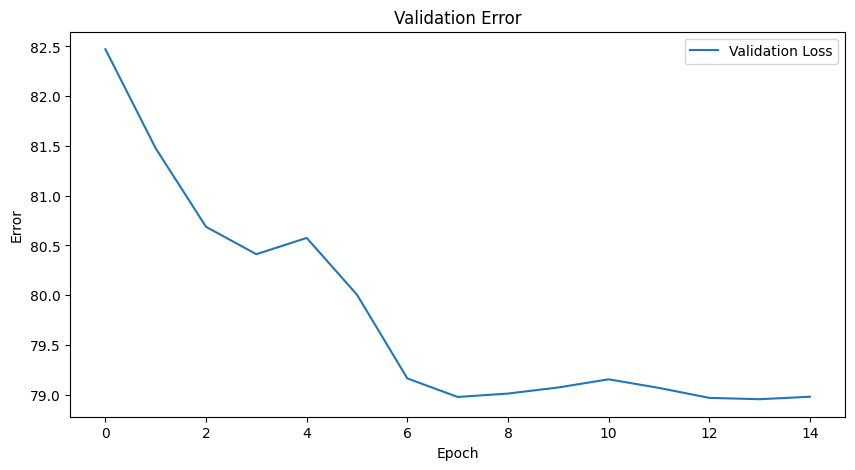

<Figure size 640x480 with 0 Axes>

In [21]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_cnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('validation_error_model_rnn.png')  # This will save the plot as an image

In [ ]:
torch.save(model.state_dict(), 'model_images/cnn-exp-6.pth')

## Experiment 9 (512 feedforward dim & no checkmate data)

In [19]:
# Reload the data with particular batch size
torch.multiprocessing.set_start_method('fork', force=True)
batch_size = 64
# Shuffling... (False gives us )
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2,pin_memory=True)

# Initialize model, loss function, and optimizer
NUM_EPOCHS = 8
d_out = len(vocab.id_to_move.keys())
# d_out = 1968
model = SENetPureThree(d_out, 512) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 2e-4
weight_decay=1e-8
learn_decay = 0.1
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

6726428


Epoch 1, Batch: 1000| Training Loss: 5.296237291097641
Epoch 1, Batch: 2000| Training Loss: 4.852479225516319
Epoch 1, Batch: 3000| Training Loss: 4.572876669009527
Epoch 1, Batch: 4000| Training Loss: 4.3714627460241315
Epoch 1, Batch: 5000| Training Loss: 4.219808275604248
Epoch 1, Batch: 6000| Training Loss: 4.0955287885268525
Epoch 1, Batch: 7000| Training Loss: 3.9942840369769503
Epoch 1, Batch: 8000| Training Loss: 3.9094056925475598
Epoch 1, Batch: 9000| Training Loss: 3.8351447305944233
Epoch 1, Batch: 10000| Training Loss: 3.7695956896543503
Epoch 1, Batch: 11000| Training Loss: 3.712406557798386
Epoch 1, Batch: 12000| Training Loss: 3.6613769728342693
Epoch 1, Batch: 13000| Training Loss: 3.6155525547907903
Epoch 1, Batch: 14000| Training Loss: 3.573239218882152
Epoch 1, Batch: 15000| Training Loss: 3.5347733852227528
Epoch 1, Batch: 16000| Training Loss: 3.4994683670699596
Epoch 1, Batch: 17000| Training Loss: 3.467550106455298
Epoch 1, Batch: 18000| Training Loss: 3.4373889

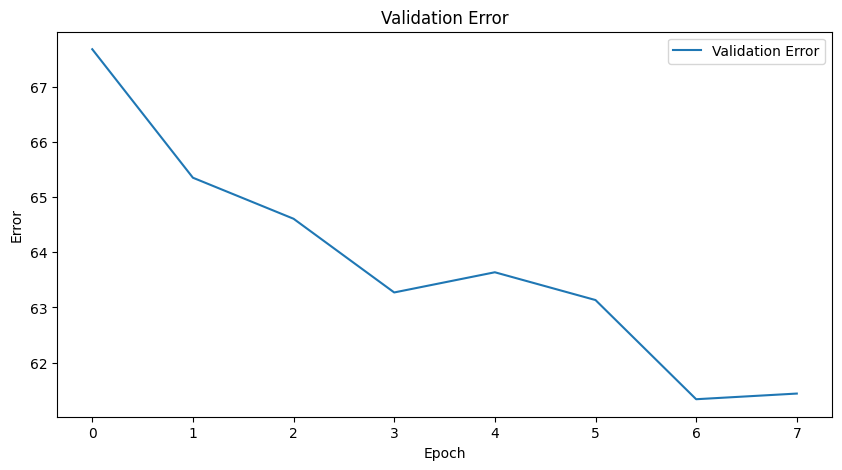

<Figure size 640x480 with 0 Axes>

In [20]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_cnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('cnn-exp-9-4-25.png')  # This will save the plot as an image

## Experiment 9 (d_model = 1024)

In [21]:
# Reload the data with particular batch size
torch.multiprocessing.set_start_method('fork', force=True)
batch_size = 128
# Shuffling... (False gives us )
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2,pin_memory=True)

# Initialize model, loss function, and optimizer
NUM_EPOCHS = 8
d_out = len(vocab.id_to_move.keys())
# d_out = 1968
model = SENetPureThree(d_out, 1024) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 1e-4
weight_decay=1e-8
learn_decay = 0.1
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

13290780


Epoch 1, Batch: 1000| Training Loss: 5.156416864871979
Epoch 1, Batch: 2000| Training Loss: 4.713804044365883
Epoch 1, Batch: 3000| Training Loss: 4.4192602796554565
Epoch 1, Batch: 4000| Training Loss: 4.210864796698093
Epoch 1, Batch: 5000| Training Loss: 4.049931286382675
Epoch 1, Batch: 6000| Training Loss: 3.9224248724778494
Epoch 1, Batch: 7000| Training Loss: 3.8185621630123685
Epoch 1, Batch: 8000| Training Loss: 3.7309930783212186
Epoch 1, Batch: 9000| Training Loss: 3.6549577979246775
Epoch 1, Batch: 10000| Training Loss: 3.5904568868160247
Epoch 1, Batch: 11000| Training Loss: 3.533218976237557
Epoch 1, Batch: 12000| Training Loss: 3.4814348851641017
Epoch 1, Batch: 13000| Training Loss: 3.4351195850739114
Epoch 1, Batch: 14000| Training Loss: 3.392602533561843
Epoch 1, Batch: 15000| Training Loss: 3.3546521767616273
Epoch 1, Batch: 16000| Training Loss: 3.320027256473899
Epoch 1, Training Loss: 3.311701797506237, Validation Error: 69.32705531339596, Validation Top-3 Accurac

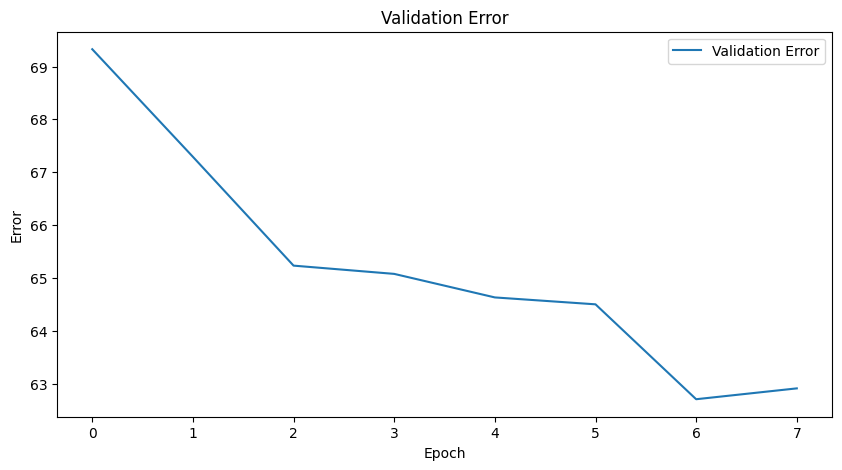

<Figure size 640x480 with 0 Axes>

In [22]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_cnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('cnn-exp-9-4-25.png')  # This will save the plot as an image

## Experiment 10 (96 channels + 5 layers)

In [26]:
# Reload the data with particular batch size
torch.multiprocessing.set_start_method('fork', force=True)
batch_size = 128
# Shuffling... (False gives us )
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2,pin_memory=True)

# Initialize model, loss function, and optimizer
NUM_EPOCHS = 8
d_out = len(vocab.id_to_move.keys())
# d_out = 1968
model = SENetPureFour(d_out, 96, 512) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 1e-4
weight_decay=1e-8
learn_decay = 0.1
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

7712180


Epoch 1, Batch: 1000| Training Loss: 5.207195224761963
Epoch 1, Batch: 2000| Training Loss: 4.777239606976509
Epoch 1, Batch: 3000| Training Loss: 4.475748863220215
Epoch 1, Batch: 4000| Training Loss: 4.260886061251163
Epoch 1, Batch: 5000| Training Loss: 4.097174075078964
Epoch 1, Batch: 6000| Training Loss: 3.9652082715034487
Epoch 1, Batch: 7000| Training Loss: 3.858884522029332
Epoch 1, Batch: 8000| Training Loss: 3.767212309628725
Epoch 1, Batch: 9000| Training Loss: 3.688270149760776
Epoch 1, Batch: 10000| Training Loss: 3.6198032940149307
Epoch 1, Batch: 11000| Training Loss: 3.559148765173825
Epoch 1, Batch: 12000| Training Loss: 3.504090076784293
Epoch 1, Batch: 13000| Training Loss: 3.455323453059563
Epoch 1, Batch: 14000| Training Loss: 3.4107954952887125
Epoch 1, Batch: 15000| Training Loss: 3.371080091110865
Epoch 1, Batch: 16000| Training Loss: 3.33439305613935
Epoch 1, Training Loss: 3.325344354383589, Validation Error: 68.93312510197897, Validation Top-3 Accuracy: 55.2

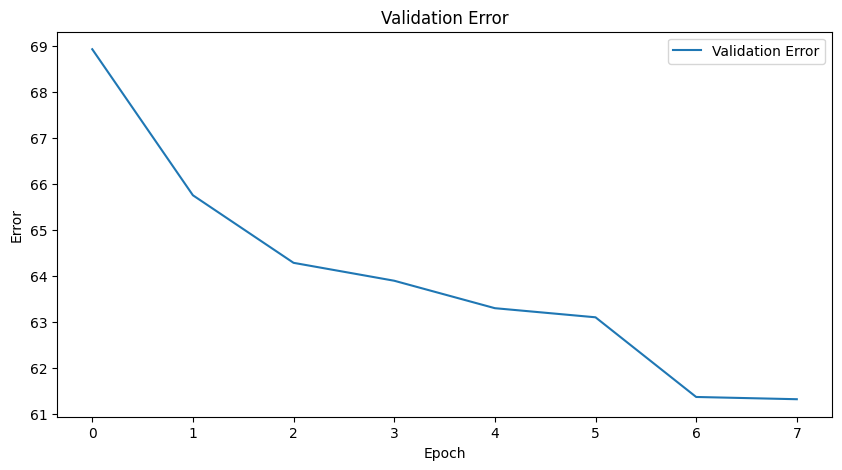

<Figure size 640x480 with 0 Axes>

In [27]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_cnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('cnn-exp-10-4-26.png')  # This will save the plot as an image

In [28]:
torch.save(model.state_dict(), 'model_images/cnn-exp-10.pth')

Epoch 1, Batch: 1000| Training Loss: 1.6381262419223785
Epoch 1, Batch: 2000| Training Loss: 1.640841254234314
Epoch 1, Batch: 3000| Training Loss: 1.6413325233856837
Epoch 1, Batch: 4000| Training Loss: 1.642258669793606
Epoch 1, Batch: 5000| Training Loss: 1.6434780809402465
Epoch 1, Batch: 6000| Training Loss: 1.6446652101278305
Epoch 1, Batch: 7000| Training Loss: 1.6457352103676115
Epoch 1, Batch: 8000| Training Loss: 1.6461203375309705
Epoch 1, Batch: 9000| Training Loss: 1.6473509871429868
Epoch 1, Batch: 10000| Training Loss: 1.6479251551628114
Epoch 1, Batch: 11000| Training Loss: 1.6488038489493457
Epoch 1, Batch: 12000| Training Loss: 1.6491522235969702
Epoch 1, Batch: 13000| Training Loss: 1.6499300643755839
Epoch 1, Batch: 14000| Training Loss: 1.6512295279502869
Epoch 1, Batch: 15000| Training Loss: 1.652386084040006
Epoch 1, Batch: 16000| Training Loss: 1.6527650385275483
Epoch 1, Training Loss: 1.6530081059006372, Validation Error: 61.5370271089252, Validation Top-3 Acc

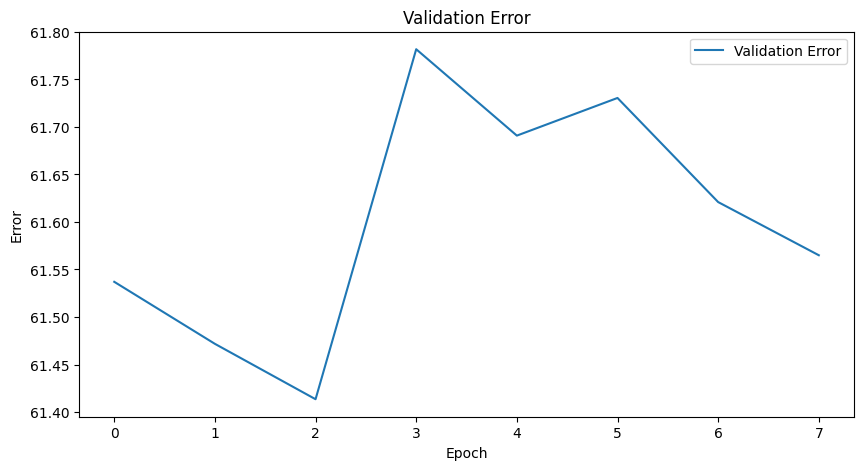

<Figure size 640x480 with 0 Axes>

In [29]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_cnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('cnn-exp-10-4-26.png')  # This will save the plot as an image

In [30]:
torch.save(model.state_dict(), 'model_images/cnn-exp-10-more.pth')